In [1]:
import torch
from torch import nn, optim
from torch.nn import Module
import torch.nn.functional as F
import os
# TO COMPLETE
import os
import torch
import numpy as np
from PIL import Image
from torch import Generator
from torch.utils.data import Dataset, random_split
import copy
from natsort import natsorted
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
device = torch.device("mps")

In [2]:
class CNNModel(Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, 1, 2)
        self.pooling = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(12*16*16,512)
        self.dropout = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 30)


    def forward(self,x):
        x = F.relu(self.pooling(self.conv1(x)))
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

def nn_train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=1):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    statsrec = np.zeros((4,epochs))
    best_acc = 0

    for e in range(epochs):
        # training
        # model.to(device)
        model.train()
        tmp_loss, tmp_correct = 0, 0
        for batch, (X, y) in enumerate(train_dataloader):
            # X, y = X.to(device), y.to(device) # Setup inputs to gpu
            y_pred = model(X) # predict the input data
            loss = loss_fn(y_pred, y) # check loss
            optimizer.zero_grad() # reset the gradiant
            loss.backward() # back propagation
            optimizer.step() # forward propagation

            tmp_correct += (torch.argmax(y_pred, dim=1) == y).sum()
            tmp_loss += loss
        train_loss.append(tmp_loss / len(train_dataloader))
        train_acc.append(tmp_correct / 10800)

        # validation
        tmp_loss, tmp_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X, y in val_dataloader:
                # X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                tmp_correct += (torch.argmax(y_pred, dim=1) == y).sum()
                tmp_loss += loss
            val_loss.append(tmp_loss / len(val_dataloader))
            val_acc.append(tmp_correct / 2700)

        statsrec[:,e] = (
            train_loss[-1].cpu().detach().numpy(),
            train_acc[-1].cpu().detach().numpy(),
            val_loss[-1].cpu().detach().numpy(),
            val_acc[-1].cpu().detach().numpy())

        if val_acc[-1] > best_acc:
            best_model_wgh = copy.deepcopy(model.state_dict())
        print(f'epoch:{e+1}---train loss:{train_loss[-1]:.4f}---train accuracy:{train_acc[-1]:.4f}---val loss:{val_loss[-1]:.4f}---val accuracy:{val_acc[-1]:.4f}')

    return best_model_wgh, statsrec


In [3]:
class_map = {}
for line in open('TinyImageNet30/class.txt', 'r'):
    class_map[line.split()[1]] = int(line.split()[0])

In [4]:
train_path='TinyImageNet30/train_set/train_set/'
image_file_map = {}
for key, value in class_map.items():
    for i in os.listdir(train_path + key):
        image_file_map[os.path.join(train_path + key + '/' + i)] = value

In [5]:
class ImageDataset(Dataset):
    def __init__(self,ids,label_mapping,transform=None):
        self.ids=ids
        self.label_mapping=label_mapping
        self.transform=transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self,index):
        image=Image.open(self.ids[index]).convert("RGB")
        #convert_tensor = transforms.ToTensor()
        #img=convert_tensor(img).permute(1,2,0)
        if self.transform:
            image = self.transform(image)

        label=self.label_mapping[self.ids[index]]

        return image, label

In [6]:
def imageDataLoader(image_file_map, batch_size=64, train_test_split=0.3, seed=0, transform=transforms.ToTensor()):

    dataset=ImageDataset(list(image_file_map.keys()), image_file_map, transform=transform)
    len_train= int(len(image_file_map) * (1 - train_test_split))
    len_vald = int(len(image_file_map) * train_test_split)

    #splitting data
    train_set, vald_set = random_split(dataset, [len_train, len_vald], generator=Generator().manual_seed(seed))

    #DataLoaders
    train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    vald_loader= DataLoader(dataset=vald_set, batch_size=batch_size, shuffle=True)

    return train_loader,vald_loader

In [7]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 64
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

cnn = CNNModel()
cnn_loss_func = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#TO COMPLETE --> Running you CNN model class
epochs = 10

state_dict, statsrec = nn_train(
    cnn,
    train_loader,
    val_loader,
    cnn_loss_func,
    cnn_optimizer,
    epochs = epochs
)

torch.save(state_dict, 'best-cnn-kagggle-param.pt')

epoch:1---train loss:3.1663---train accuracy:0.1019---val loss:2.9535---val accuracy:0.1552
epoch:2---train loss:2.7932---train accuracy:0.2013---val loss:2.6240---val accuracy:0.2496
epoch:3---train loss:2.5524---train accuracy:0.2644---val loss:2.4739---val accuracy:0.3011
epoch:4---train loss:2.3919---train accuracy:0.3128---val loss:2.3346---val accuracy:0.3285
epoch:5---train loss:2.2574---train accuracy:0.3461---val loss:2.2929---val accuracy:0.3504
epoch:6---train loss:2.1290---train accuracy:0.3817---val loss:2.2162---val accuracy:0.3559
epoch:7---train loss:2.0281---train accuracy:0.4092---val loss:2.1444---val accuracy:0.3767
epoch:8---train loss:1.9374---train accuracy:0.4292---val loss:2.1550---val accuracy:0.3770
epoch:9---train loss:1.8393---train accuracy:0.4600---val loss:2.1362---val accuracy:0.3841
epoch:10---train loss:1.7581---train accuracy:0.4803---val loss:2.1687---val accuracy:0.3867


In [16]:
cnn = CNNModel()
cnn.load_state_dict(torch.load('best-cnn-kagggle-param.pt'))

<All keys matched successfully>

In [22]:
# Your code here!
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

img_path = list(image_file_map.keys())[0]
cam_extractor = SmoothGradCAMpp(cnn, input_shape=(3, 64, 64), target_layer='conv2')

In [11]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 1
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

In [35]:
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (64, 64)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = cnn(input_tensor.unsqueeze(0))
cams = cam_extractor(out.squeeze(0).argmax().item(), out.cpu())

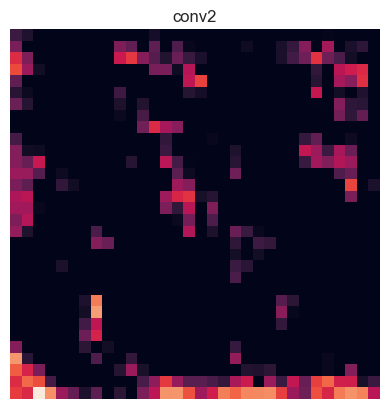

In [36]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
    plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

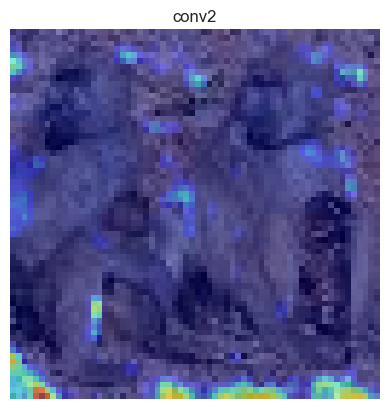

In [37]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
    result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()